In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/car-evaluation-data-set/car_evaluation.csv')
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


Columns are missing, so we must assign them.

In [3]:
df.columns = ['buying','maint','doors','persons','lug_boot','safety','class']
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
len(df)

1727

There are 1727 examples in the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1727 non-null   object
 1   maint     1727 non-null   object
 2   doors     1727 non-null   object
 3   persons   1727 non-null   object
 4   lug_boot  1727 non-null   object
 5   safety    1727 non-null   object
 6   class     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [6]:
for col in df.columns:
    print(col, set(df[col].tolist()))

buying {'vhigh', 'med', 'high', 'low'}
maint {'vhigh', 'med', 'high', 'low'}
doors {'3', '5more', '4', '2'}
persons {'4', 'more', '2'}
lug_boot {'big', 'small', 'med'}
safety {'med', 'high', 'low'}
class {'unacc', 'good', 'acc', 'vgood'}


For this dataset, we can assume all data as categorical. No data transformation is requireed.

In [7]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

There are no null rows in the data set.

### Train-Test Splitting

In [8]:
train_ratio = 0.8
n_train = int(len(df) * train_ratio)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True) 
# frac = 1 means shuffle 100% of the dataset randomly
# random_state = 42 is a seed for the shuffling 
# reset_index will drop existing indexes (but it stores the old indices too in the table, so drop=True removes that)

train_df = df_shuffled[:n_train]
test_df = df_shuffled[n_train:]

In [9]:
print(len(train_df)) 
print(len(test_df))

1381
346


In [10]:
for col in train_df.columns:
    print(col, set(train_df[col].tolist()))

buying {'vhigh', 'med', 'high', 'low'}
maint {'vhigh', 'med', 'high', 'low'}
doors {'3', '5more', '4', '2'}
persons {'4', 'more', '2'}
lug_boot {'big', 'small', 'med'}
safety {'high', 'med', 'low'}
class {'unacc', 'good', 'acc', 'vgood'}


Hence, all categories are present in the train dataset as well.

### Univariate Analysis

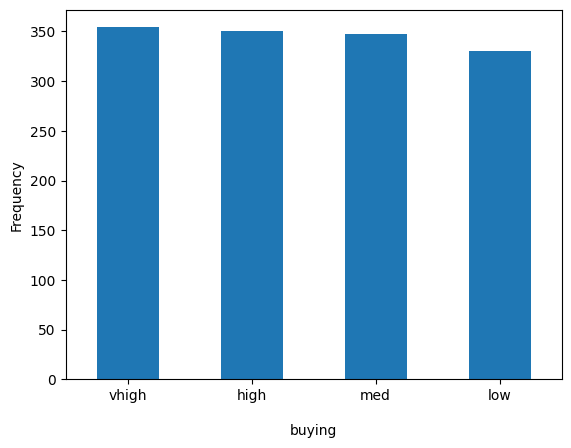

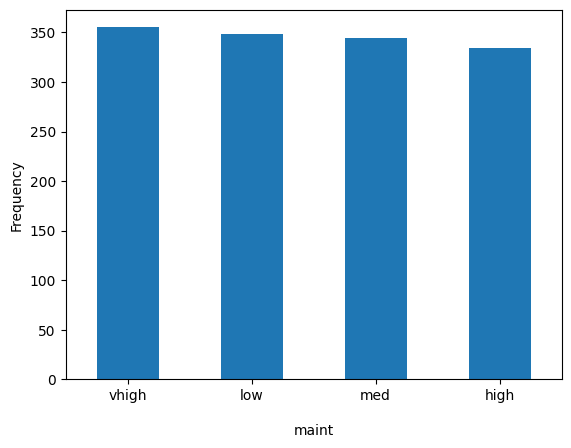

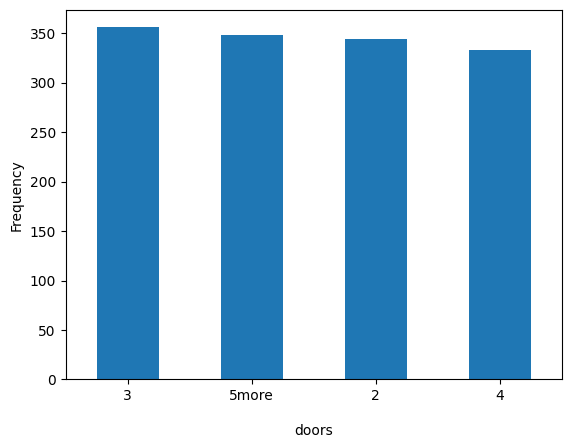

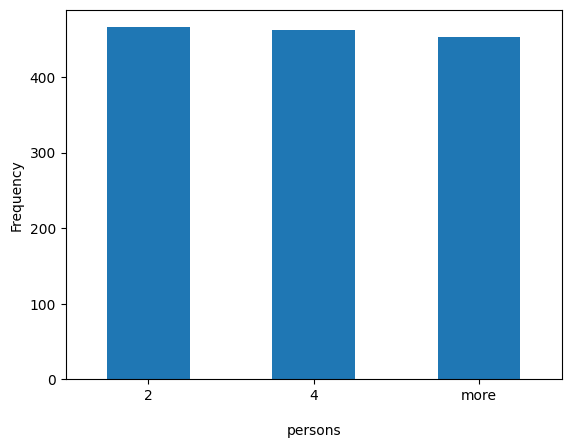

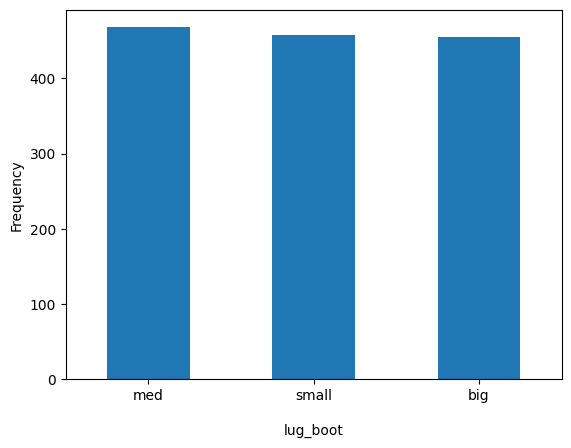

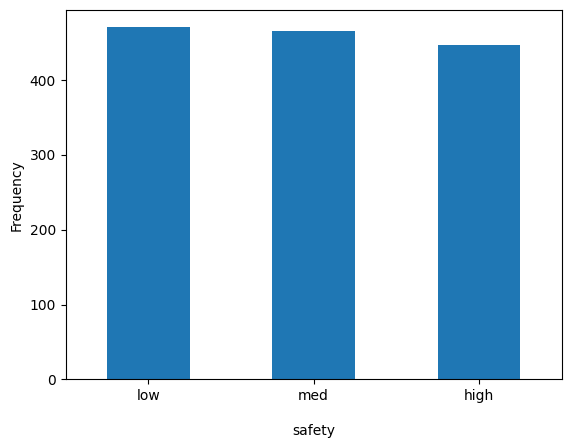

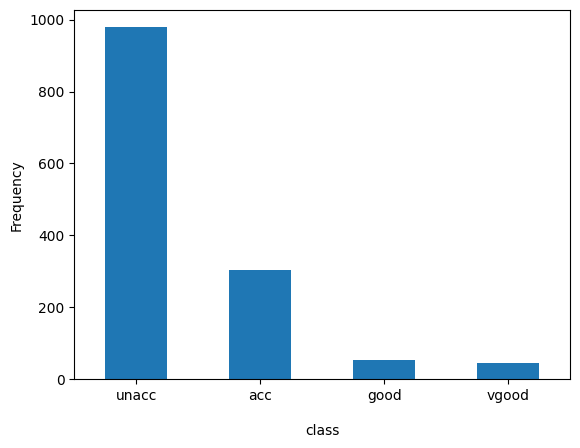

In [11]:
for col in train_df.columns:
    counts = train_df[col].value_counts()
    counts.plot(kind='bar')
    plt.xlabel(col, labelpad=15)
    plt.xticks(rotation=0)
    plt.ylabel("Frequency")
    plt.show()

### Bivariate Analysis

Let us only analyse the heatmaps for class = good or vgood. This is because we only need positive examples for the find-S algorithm, and there are a lot of unaccurate class cars, which skews the heatmap.

In [12]:
def plot_heatmap(col1, col2):
    filtered = train_df[train_df['class'].isin(['good', 'vgood'])]
    cross_tab = pd.crosstab(filtered[col1], filtered[col2])

    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Frequency Heatmap between {col1} and {col2}')
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.show()

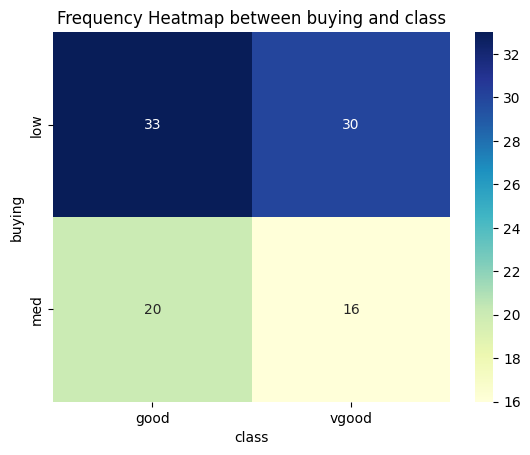

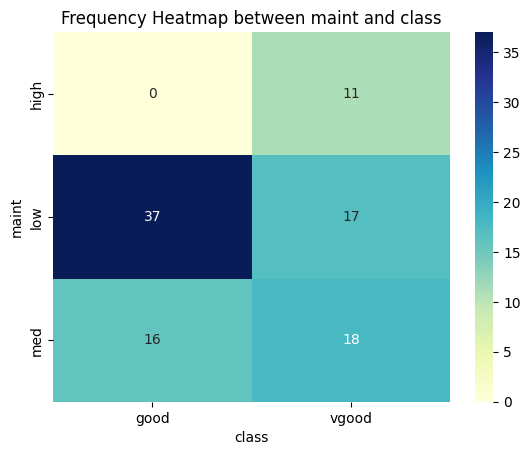

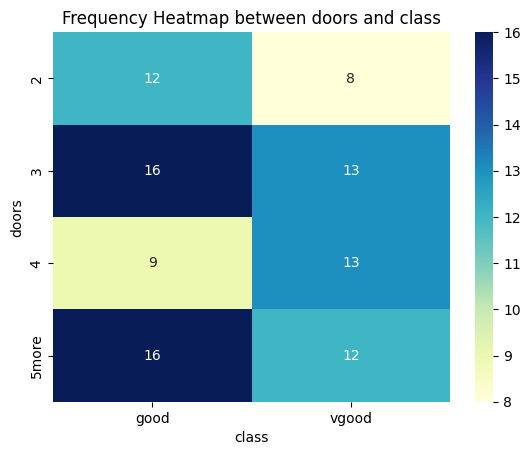

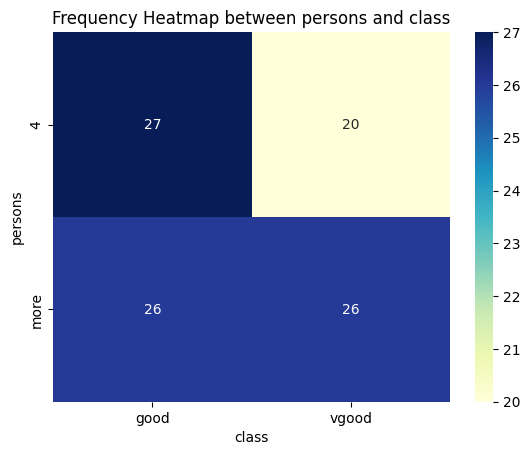

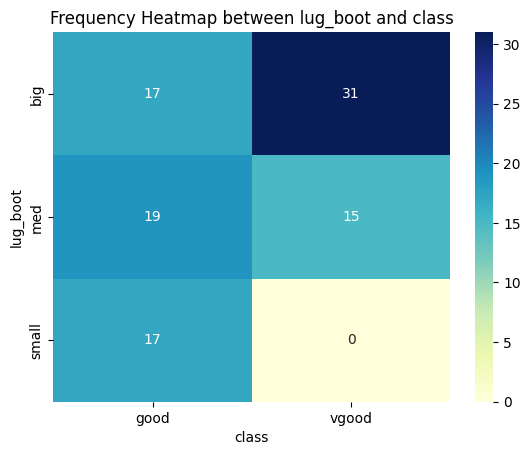

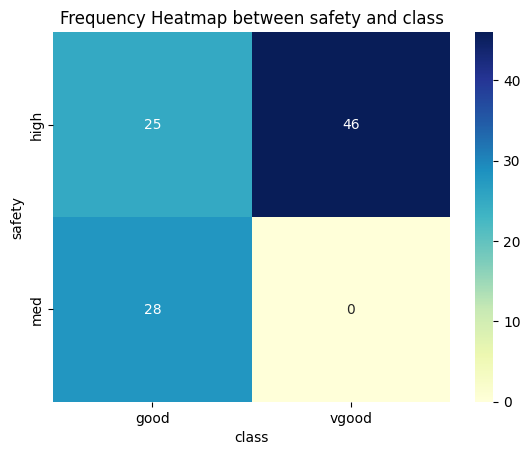

In [13]:
for col in train_df.columns:
    if col != 'class':
        plot_heatmap(col, 'class')

### Find-S Algorithm

We can drop the columns doors and person for find S as they are equally distributed amongst good and very good cars. So the hypothesis for it will be general only i.e. '?'.

We run the algorithm for 2 cases:
1. Both good and vgood are considered as positive examples
2. Only vgood is considered as positive example

In [14]:
# Find S Algorithm
def find_s(df, positive_examples):
    """Performs the find-S algorithm on the input dataset and positive examples"""
    target_column = 'class'
    df = df.drop(['persons', 'doors'], axis=1)
    
    # get rows with positive class 
    positive_examples = df[df[target_column].isin(positive_examples)].drop(columns=[target_column])
    
    # intialise hypothesis with first example
    hypothesis = positive_examples.iloc[0].copy()
    
    # iterate over remaining positive examples
    for i in range(1, len(positive_examples)):
        for attr in positive_examples.columns:
            if hypothesis[attr] != positive_examples.iloc[i][attr]:
                hypothesis[attr] = '?'
    
    return hypothesis

In [15]:
h1 = find_s(train_df, ['vgood', 'good'])
h2 = find_s(train_df, ['vgood'])

### Model Evaluation

In [16]:
def evaluate_hypothesis(h, positive_labels):
    correct = 0
    total = len(test_df)

    for _, row in test_df.iterrows():
        # 1 -> positive, 0 -> negative
        actual = 1 if row['class'] in positive_labels else 0

        predicted = 1
        for col in h.index:
            if h[col] != '?' and h[col] != row[col]:
                predicted = 0
                break 

        if actual == predicted:
            correct += 1

    accuracy = round((correct / total) * 100, 3)
    print("Hypothesis: ")
    print(h)
    print("Accuracy: ")
    print(accuracy)

In [17]:
evaluate_hypothesis(h1, ['vgood', 'good'])

Hypothesis: 
buying      ?
maint       ?
lug_boot    ?
safety      ?
Name: 10, dtype: object
Accuracy: 
10.116


In [18]:
evaluate_hypothesis(h2, ['vgood'])

Hypothesis: 
buying         ?
maint          ?
lug_boot       ?
safety      high
Name: 10, dtype: object
Accuracy: 
67.919


### Size of Hypothesis Space

Let us see number of values for each category in the original dataset.

In [19]:
for col in df.columns:
    print(col, len(set(df[col])))

buying 4
maint 4
doors 4
persons 3
lug_boot 3
safety 3
class 4


Apart from this, in the hypothesis we can have '?' and 'φ' as well.  
So each column can take n + 2 values where n is the number of unique values for each column and the 2 corresponds to ? and φ.    
For all columns, we multiply the contributions to get the total hypothesis space  

$$ Size = \prod_{\text{columns}} (n + 2)$$

In [20]:
size = 1
for col in df.columns:
    size *= (len(set(df[col])) + 2)

size

162000


This is the number of syntactically different hypothesis. <br>
Every hypothesis containing one or more 'φ' will reject the empty set of instances. <br>
So the number of semantically different hypothesis is  <br>

$$ Size = 1 + \prod_{\text{columns}} (n + 1)$$

In [21]:
size = 1
for col in df.columns:
    size *= (len(set(df[col])) + 1)

size + 1

40001

Note: In our hypothesis, we did not consider the columns 'persons' and 'doors'. Hence, for these columns, our hypothesis indicates the value '?'.